In [1]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
class CnnNet(torch.nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, (3,3))
        
        self.drop1 = torch.nn.Dropout2d(0.25)
        self.drop2 = torch.nn.Dropout2d(0.5)

        self.fc1 = torch.nn.Linear(2704, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, 1)

In [38]:
def train( model, device, train_loader, epoch):
    optimizer = optim.Adadelta(model.parameters(), lr=1)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    train_loss=0
    model.train()
    no_batches=0
    correct = 0
    train_labels=dict()
    local_gradloss=[]
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        #print(loss)
        train_loss += loss.item()
        _, pred = output.max(1)
        correct += pred.eq(target).sum().item()
        with torch.no_grad():
            grads_p = torch.autograd.grad(loss, model.parameters(), create_graph=True)[0]
            local_gradloss.append(grads_p.norm(2).detach().cpu().item())

        loss.backward(retain_graph=True)
        optimizer.step()
        pred_flatten=pred
        for i in range(len(pred_flatten)):
            if pred_flatten[i]==target[i]:
                if target[i].item() in train_labels:
                    train_labels[target[i].item()]+=1
                else:
                    train_labels[target[i].item()]=1
        

    train_loss/=len(train_loader.dataset)
    accuracy = 100 * correct / len(train_loader.dataset)
    print("Training, Epoch:", epoch, "loss:", train_loss, "accuracy:", accuracy)  
    return train_loss, accuracy, train_labels, np.mean(local_gradloss)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    test_labels=dict()
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss= loss_fn(output, target)  # sum up batch loss
            test_loss+=loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += (pred.flatten()==target).sum().item()
            pred_flatten=pred.flatten()
            for i in range(len(pred_flatten)):
                if pred_flatten[i]==target[i]:
                    if target[i].item() in test_labels:
                        test_labels[target[i].item()]+=1
                    else:
                        test_labels[target[i].item()]=1
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset), test_labels

In [39]:
transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)

use_cuda = torch.cuda.is_available()
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")
train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 64}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)


train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

actual_train_labels=dict()
for data, target in train_loader:
    for i in range(len(target)):
        if target[i].item() in actual_train_labels:
            actual_train_labels[target[i].item()]+=1
        else:
            actual_train_labels[target[i].item()]=1
            
actual_test_labels=dict()
for data, target in test_loader:
    for i in range(len(target)):
        if target[i].item() in actual_test_labels:
            actual_test_labels[target[i].item()]+=1
        else:
            actual_test_labels[target[i].item()]=1


In [40]:
def return_train_test_loader(dataset1, dataset2, batchSize):
    device = torch.device("cuda" if use_cuda else "cpu")
    train_kwargs = {'batch_size': batchSize}
    test_kwargs = {'batch_size': batchSize}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    
    return train_loader, test_loader

In [41]:
def cal_sentivity(pred_tr, actual_tr, pred_tst, actual_tst):
    pred_sum_tr= sum([ pred_tr[p] for p in pred_tr])
    actual_sum_tr=sum([actual_tr[p] for p in actual_tr])
    pred_sum_tst = sum([ pred_tst[p] for p in pred_tst])
    actual_sum_tst = sum([ actual_tst[p] for p in actual_tst])
    
    return (pred_sum_tr + pred_sum_tst)/(actual_sum_tr + actual_sum_tst)

In [42]:
def returnModelAccAndLoss(device, dataset1, dataset2):
    epochs=10
    train_loss=[]
    test_loss=[]
    accuracy_train=[]
    accuracy_test=[]
    sentivity=[]
    b_size=[]
    batch_size=32
    sensitivity_train=[]
    while batch_size<pow(10, 4):
        model = CnnNet().to(device)
        train_loader, test_loader=return_train_test_loader(dataset1, dataset2, batch_size)
        tr_label=None
        for ep in range(epochs):
            tr_loss, tr_accuracy, tr_label, sens_tr =train(model, device, train_loader, ep)
            if ep==epochs-1:
                sensitivity_train.append(sens_tr)
                train_loss.append(tr_loss)
                accuracy_train.append(tr_accuracy)
        tst_loss, tst_accuracy, tst_label = test(model, device, test_loader)
        sentivity.append(cal_sentivity(tr_label, actual_train_labels, tst_label, actual_test_labels))
        test_loss.append(tst_loss)
        accuracy_test.append(tst_accuracy)
        b_size.append(batch_size)
        batch_size=int(batch_size*2)
    return train_loss, accuracy_train, test_loss, accuracy_test, sentivity, b_size, sensitivity_train

In [43]:
train_loss_1, accuracy_train_1, test_loss_1, test_accuracy_1, sentivity,  b_size, sensitivity_train = returnModelAccAndLoss(device, dataset1, dataset2)


Training, Epoch: 0 loss: 0.17343203160526074 accuracy: 94.69166666666666
Training, Epoch: 1 loss: 0.054759158760862195 accuracy: 98.42666666666666
Training, Epoch: 2 loss: 0.036836025660475204 accuracy: 98.97333333333333
Training, Epoch: 3 loss: 0.027772473134822666 accuracy: 99.245
Training, Epoch: 4 loss: 0.02238126034291945 accuracy: 99.41
Training, Epoch: 5 loss: 0.018660073791129897 accuracy: 99.54166666666667
Training, Epoch: 6 loss: 0.01587971795808381 accuracy: 99.62
Training, Epoch: 7 loss: 0.013394767488309428 accuracy: 99.67666666666666
Training, Epoch: 8 loss: 0.012187261754165889 accuracy: 99.72
Training, Epoch: 9 loss: 0.011429766678333146 accuracy: 99.72833333333334

Test set: Average loss: 0.0666, Accuracy: 9860/10000 (99%)

Training, Epoch: 0 loss: 0.2543890364972254 accuracy: 92.01333333333334
Training, Epoch: 1 loss: 0.06718294863089298 accuracy: 97.99666666666667
Training, Epoch: 2 loss: 0.04396193037138243 accuracy: 98.67
Training, Epoch: 3 loss: 0.0318801982681926

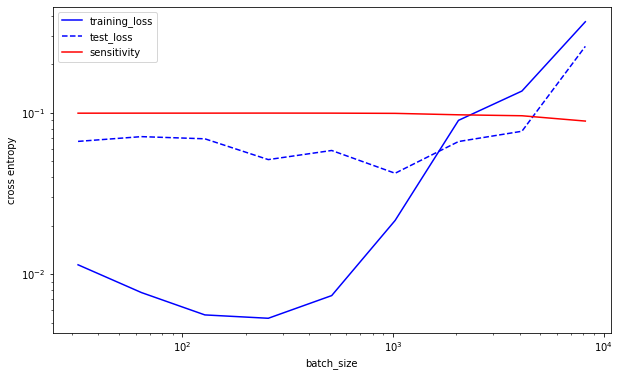

In [50]:
import matplotlib.pyplot as plt
plt1 = plt.figure(figsize=(10, 6))
plt.plot(np.array(b_size), np.array(train_loss_1),'b', label='training_loss')
plt.plot(np.array(b_size), np.array(test_loss_1), 'b--', label='test_loss')
plt.plot(np.array(b_size), [s*0.1 for s in np.array(sentivity)], 'r', label='sensitivity')
plt.xscale('log')
#plt.scale('log')
plt.yscale('log')
# naming the x axis
plt.xlabel('batch_size')
# naming the y axis
plt.ylabel('cross entropy') 
plt.legend()
plt.show()

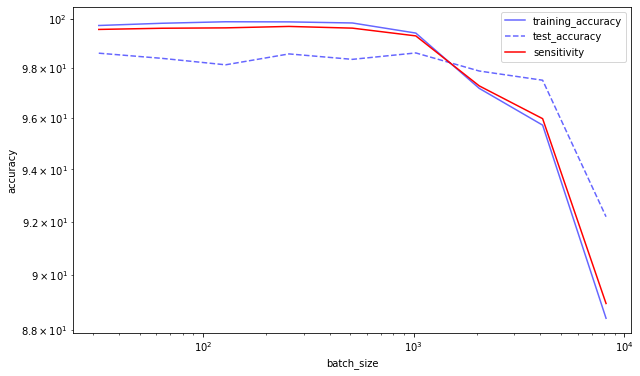

In [52]:
plt1 = plt.figure(figsize=(10, 6))
plt.plot(np.array(b_size), np.array(accuracy_train_1), 'b', label='training_accuracy', alpha=0.6)
plt.plot(np.array(b_size), np.array(test_accuracy_1), 'b--', label='test_accuracy', alpha=0.6)
plt.plot(np.array(b_size), [s*100 for s in sentivity], 'r', label='sensitivity')
plt.xscale('log')
plt.yscale('log')
# naming the x axis
plt.xlabel('batch_size')
# naming the y axis
plt.ylabel('accuracy') 
plt.legend()
plt.show()